In [33]:
from selenium import webdriver as wd
import urllib

In [34]:
driver = wd.Chrome('../tool/chromedriver75.0.3770.140.exe')

In [35]:
target_url = 'http://www.opinet.co.kr/searRgSelect.do'

In [36]:
#해당사이트가 중간 페이지를 직접 접속하는  부분을 거부하기 때문에
# 시간차를 
import time 
for n in range(2):
    driver.get( target_url)
    time.sleep(5)

- 1. 시도 정보를 추출하여 리스트화
- 2. 리스트를 반복하면서 해당 시도 밑에 시군구 리스트화
- 3. 시군구 리스트를 반복하면서 읍면동 리스트화
- 4. 읍면동 리스트를 반복하면서 -> 조회 -> 다운로드 순으로 진행되는 것이 기본
- 5. 사이트 관찰결과, 시도, 시군구, 읍면동, 정보가 새로 세팅되면 화면의 DOM이 모두 새로구성이 되는 문제가 있어서 반복문 안에서는 반드시 시도, 시군구, 읍면동을 새로 잡아줘야한다!!!(매우중요) 
- 6. 시군구를 반복하면서 바로 조회 및 다운로드로 전개하겠다(여기서는)

In [37]:
# 시/도 리스트 획득 구간
# 1. 구간
sidos = [ option.get_attribute('value') 
        for option in driver.find_elements_by_css_selector('#SIDO_NM0 > option')
        if option.get_attribute('value')
        ]
# 데이터의 상위값과, 하위값 조사를 통해 샘플링으로 확인
sidos[:2], sidos[-2:], sidos[1:2]

(['서울특별시', '부산광역시'], ['경상남도', '제주특별자치도'], ['부산광역시'])

In [38]:
# 2. 시도 리스트를 반복하면서 해당 시도 밑에 시군구 리스트화
# sidos중에 부산만 대상으로 수집하겠다
# 시퀀서: 연속데이터 자료
for sido in sidos[1:2]:
    # 2-1. sido 대상 찾아서
    sido_tag = driver.find_element_by_id('SIDO_NM0') # sido변수명이 겹쳐서 tag를 찾는 sido라 하여 sido_tag라한다
    # 2-2. sido 값을 설정
    sido_tag.send_keys( sido ) # 값을 설정하는 코드임, ajax를 통해서 서버를 연결해준다
    # 2-2-2. 잠시대기( ajax 통신후 화면이 재구성될때까지 )
    time.sleep(6)
    # 2-3. 시군구 리스트 획득
    sigungus = [ option.get_attribute('value') 
        for option in driver.find_elements_by_css_selector('#SIGUNGU_NM0 > option')
        if option.get_attribute('value')
    ] 
    print( sido, sigungus[:2])    
    # 2-4. 반복~, 3단계로 진입
    # 3. 시군구 리스트를 반복하면서 -> 조회(대기시간이 필요하다(대기시간 설정:5초정도)) -> 엑셀저장
    for sigungu in sigungus:
        # 3-1. 시군구 태그를 찾아서
        sigungu_tag = driver.find_element_by_id('SIGUNGU_NM0')
        # 3-2. 시군구값 설정
        sigungu_tag.send_keys( sigungu)
        # 3-3. 잠시대기
        time.sleep(5)
        # 3-4. 엑셀 저장
        driver.find_element_by_id('glopopd_excel').click()

부산광역시 ['강서구', '금정구']


### 데이터 수집 완료
- 수십개의 엑셀파일을 반복적으로 읽어서 DataFrame으로 구성하기

In [39]:
# 파일의 경로를 알아야 한다
# glob 특징 : 위치상에 존재하는 파일들을 패턴을 지정하여 목록을 구할 수 있다
from glob import glob
import pandas as pd

In [43]:
# 부산관한 시군구에 조회된 엑셀 자료를 읽을 수 있게 파일 경로를 리스트화
down_files = glob( 'C:/Users/User/Desktop/files/지역*.xls' )
down_files[:2], down_files[-2:]

(['C:/Users/User/Desktop/files\\지역_위치별(주유소) (1).xls',
  'C:/Users/User/Desktop/files\\지역_위치별(주유소) (10).xls'],
 ['C:/Users/User/Desktop/files\\지역_위치별(주유소) (9).xls',
  'C:/Users/User/Desktop/files\\지역_위치별(주유소).xls'])

In [44]:
# 그냥 참고만( 아직 배우기전 )
# conda install xlrd
tmp_raws = []
for file in down_files:
    tmp = pd.read_excel(file, header=2)
    tmp_raws.append( tmp )
# 여기는 데이터 확인차!!
st_raw = pd.concat( tmp_raws )
# 아나콘다 -> 프롬프트 ->  conda install xlrd 설치시행

In [45]:
st_raw

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1438,1288,-
1,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1438,1288,-
2,부산광역시,청룡명품주유소,부산 금정구 중앙대로 2130,현대오일뱅크,051-508-5150,N,-,1442,1292,-
3,부산광역시,은마석유 노포주유소,부산 금정구 중앙대로 2191 (노포동),GS칼텍스,051-508-1645,Y,-,1443,1293,1050
4,부산광역시,지에스칼텍스(주)신창주유소,부산 금정구 중앙대로 1698 (부곡동),GS칼텍스,051-581-1212,N,1730,1455,1315,990
5,부산광역시,한솔유화(주) 직영 한길주유소,부산 금정구 중앙대로 1646 (부곡동),현대오일뱅크,051-581-0875,N,-,1455,1315,1000
6,부산광역시,거북이주유소(SK),부산 금정구 중앙대로 1672 (부곡동),SK에너지,051-516-5151,Y,-,1455,1315,-
7,부산광역시,금두꺼비주유소,부산광역시 금정구 부곡로 67 (부곡동),현대오일뱅크,051-583-6433,Y,-,1455,1315,990
8,부산광역시,광신석유(주)직영경부고속주유소,부산 금정구 중앙대로1720번길 7 (부곡동),SK에너지,051-517-6011,Y,-,1455,1315,1010
9,부산광역시,금샘로주유소,부산 금정구 금샘로 460 (남산동),SK에너지,051-517-0220,Y,1655,1455,1315,-


- 응용 : 시군구 단위 => 읍면동 단위
> 주유소정보데이터 부산시 행정구역으로 표현
> 자치구별 가장 저렴한 주유소 마킹
> 행정구역별 주유가격 평균을 통해서 칼라맵으로 표시, 휘발유 기준, 가격없는 주유소는 배제
> 브랜드별(6개) 알뜰주유소 Vs 브랜드 대비, 진짜 싼지 체크!! => seaborn의 박스플롯과 스완플롯을 활용하여 시각화환다
> 브랜드, 셀프여부, 휘발유냐 경유냐, 등등

In [ ]:
# 가장 먼저 던질 데이터를 확인하는 것이 먼저다

In [49]:
# 주소가 xx등이 탐색되는 있는 주유소 정보
tmp = st_raw[ st_raw['주소'].apply( lambda x: x.find('동')>0) ]
tmp.shape

(325, 10)

In [53]:
# 값 중복성 제거를 통한 결측치 및 타입 확인
st_raw['휘발유'].unique()

array([1438, 1442, 1443, 1455, 1458, 1463, 1468, 1483, 1488, 1497, 1498,
       1529, 1539, 1540, 1577, 1665, 1440, 1448, 1473, 1478, 1548, 1437,
       1477, 1485, 1493, 1495, 1547, 1620, 1638, 1648, 1453, 1465, 1470,
       1482, 1489, 1518, 1519, 1598, 1628, 1644, 1408, 1565, 1427, 1434,
       1435, 1445, 1447, 1469, 1474, 1475, 1480, 1503, 1505, 1510, 1523,
       1553, 1563, 1613, 1459, 1479, 1487, 1490, 1545, 1649, 1419, 1420,
       1424, 1457, 1467, 1499, 1513, 1538, 1549, 1569, 1585, 1446, 1508,
       1845, 1462, 1699, 1425, 1428, 1429, 1471, 1528, 1575, 1433, 1466,
       1544, 1414, 1415, 1418, 1464, 1579, 1597, 1599, 1739, '1430',
       '1447', '1448', '1452', '1458', '1463', '1468', '1478', '1487',
       '1488', '1495', '1497', '1498', '1499', '1508', '1518', '1563',
       '-', '1405', '1415', '1437', '1438', '1445', '1465', '1479',
       '1509', '1529', '1543'], dtype=object)

In [62]:
# 휘발유 기준으로 데이터가 정렬이 되어야 한다
# 지도 시각화의 기준점이 휘발유가격이므로, 휘발유 가격을 정제하여 의미있는 데이터만 남긴다
st_raw_price_exist = st_raw[st_raw['휘발유'] !='-']  # 휘발유 가격중 - 이 안들어가있는 데이터를 추출한다
st_raw_price_exist.shape

(418, 10)

In [74]:
st_raw_price_exist['휘발유'] = st_raw_price_exist['휘발유'].astype(int)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [68]:
st_raw_price_exist['휘발유'].unique()

array([1438, 1442, 1443, 1455, 1458, 1463, 1468, 1483, 1488, 1497, 1498,
       1529, 1539, 1540, 1577, 1665, 1440, 1448, 1473, 1478, 1548, 1437,
       1477, 1485, 1493, 1495, 1547, 1620, 1638, 1648, 1453, 1465, 1470,
       1482, 1489, 1518, 1519, 1598, 1628, 1644, 1408, 1565, 1427, 1434,
       1435, 1445, 1447, 1469, 1474, 1475, 1480, 1503, 1505, 1510, 1523,
       1553, 1563, 1613, 1459, 1479, 1487, 1490, 1545, 1649, 1419, 1420,
       1424, 1457, 1467, 1499, 1513, 1538, 1549, 1569, 1585, 1446, 1508,
       1845, 1462, 1699, 1425, 1428, 1429, 1471, 1528, 1575, 1433, 1466,
       1544, 1414, 1415, 1418, 1464, 1579, 1597, 1599, 1739, 1430, 1452,
       1405, 1509, 1543], dtype=int64)

In [71]:
st_raw_price_exist['휘발유'].dtypes

dtype('int32')

In [77]:
st_raw_price_exist.head(2)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1438,1288,-
1,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1438,1288,-


In [78]:
tmp_gu = st_raw_price_exist['주소'].apply( lambda x: x.split()[1])  # 주소가 하나하나 넘어온다
st_raw_price_exist['자치구'] = tmp_gu

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [79]:
# 부산의 총 자치구 중복성 검사, 16개 확인 완료
st_raw_price_exist['자치구'].unique(), len(st_raw_price_exist['자치구'].unique())

(array(['금정구', '서구', '수영구', '연제구', '영도구', '중구', '해운대구', '기장군', '남구', '동구',
        '동래구', '부산진구', '북구', '사상구', '사하구', '강서구'], dtype=object), 16)

In [81]:
st_raw_gasoline = pd.pivot_table( st_raw_price_exist, index='자치구' ) # 평균 휘발유 값으로 들어온다

In [82]:
st_raw_gasoline.sort_values(by='휘발유')

,휘발유
자치구,
기장군,1460.413043
북구,1466.315789
연제구,1467.235294
서구,1469.416667
사상구,1470.785714
동래구,1472.458333
사하구,1473.696970
강서구,1473.833333
부산진구,1474.458333


In [83]:
# min, max, scaler를 이용한 정규화를 통해서 가격비율 컬럼을 생성
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [84]:
x = st_raw_gasoline.values  # x는 시리즈가 된다
x_scaled = min_max_scaler.fit_transform( x.astype(float) )
x_scaled

array([[0.18595311],
       [0.33028767],
       [0.        ],
       [0.33988797],
       [0.49586827],
       [0.16690095],
       [0.19461318],
       [0.08178914],
       [0.14372494],
       [0.18406364],
       [0.12475526],
       [0.52651474],
       [0.0945299 ],
       [1.        ],
       [0.36146393],
       [0.26180647]])

In [87]:
tmp = pd.DataFrame( x_scaled, columns=['휘발유정규화'], index=st_raw_gasoline.index)

In [88]:
tmp.head(2)

,휘발유정규화
자치구,
강서구,0.185953
금정구,0.330288


In [89]:
import json
import folium
import pandas as pd

In [90]:
gps = [35.1592715,129.0552231]

In [95]:
geo_str = json.load( open( '../pandas/data/busan.json', encoding='utf-8' ) )

In [97]:
map_busan = folium.Map( location=gps, zoom_start=11 )
folium.Choropleth( geo_data = geo_str
                 , name='busan'
                 , data=tmp
                 , columns=[tmp.index, '휘발유정규화'] # tmp의 인덱스
                 , key_on='feature.id'
                 , fill_color='PuRd'
                 , legend_name='부산시 자치구별 휘발유가격 비율'
                 ).add_to(map_busan)
map_busan

In [98]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
from korea_font import initKoreaFontLoad
initKoreaFontLoad()

Malgun Gothic


In [107]:
import seaborn as sns

In [108]:
sns.set_style('whitegrid')

In [115]:
st_raw_price_exist.columns

Index(['지역', '상호', '주소', '상표', '전화번호', '셀프여부', '고급휘발유', '휘발유', '경유', '실내등유',
       '자치구'],
      dtype='object')

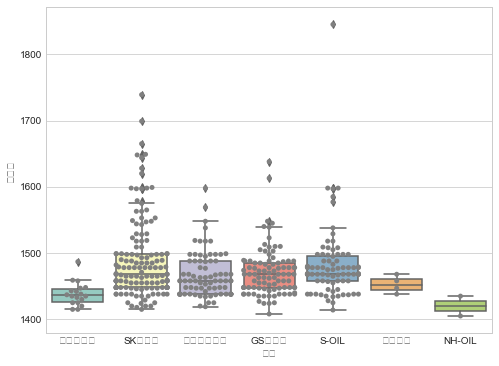

In [121]:
plt.figure( figsize=( 8, 6 ) )
sns.boxplot( x=st_raw_price_exist['상표'], y=st_raw_price_exist['휘발유'], palette='Set3' )
sns.swarmplot( x=st_raw_price_exist['상표'], y=st_raw_price_exist['휘발유'], color='0.5' )
plt.show()
